In [1]:
import numpy as np
import cupy as cp
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import cv2
import os, math

# Load Data

In [2]:
def load_data(dataroot='Yale_Face_Database', scale=0.5):
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    
    # training data
    filenames = os.listdir(os.path.join(dataroot, 'Training'))
    
    for filename in filenames:
        img = cv2.imread(os.path.join(dataroot, 'Training', filename), cv2.IMREAD_GRAYSCALE) / 255
        img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        
        label = int(filename.split('.')[0][-2:]) - 1
        
        X_train.append(img)
        Y_train.append(label)
    
    
    # testing data
    filenames = os.listdir(os.path.join(dataroot, 'Testing'))
    
    for filename in filenames:
        img = cv2.imread(os.path.join(dataroot, 'Testing', filename), cv2.IMREAD_GRAYSCALE) / 255
        img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        
        label = int(filename.split('.')[0][-2:]) - 1
        
        X_test.append(img)
        Y_test.append(label)
    
    X_train = np.asarray(X_train)
    Y_train = np.asarray(Y_train)
    X_test = np.asarray(X_test)
    Y_test = np.asarray(Y_test)
    
    return X_train, Y_train, X_test, Y_test

In [3]:
X_train, Y_train, X_test, Y_test = load_data()
HEIGHT, WIDTH = X_train.shape[1:]

In [4]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Utils

In [5]:
def eigh(X):
    # X: symmetric numpy 2d array
    # return (eigenvalue, eigenvector)
    
    # calculate on GPU
    eigenvalue, eigenvector = cp.linalg.eigh(cp.asarray(X))
    
    # move to CPU
    eigenvalue = eigenvalue.get()
    eigenvector = eigenvector.get()
    
    return eigenvalue, eigenvector

In [6]:
def show_basis_faces(X, H, W):
    # X: (N, Height, Width)
    
    plt.figure(figsize=(12, 12))
    
    N = X.shape[0]
    s = math.ceil(N ** 0.5) # grid size
    
    for i in range(N):
        plt.subplot(s, s ,i + 1)
        plt.axis('off')
        plt.imshow(X[i].reshape(H, W), cmap='gray')
    
    plt.show()

In [7]:
def show_reconstruct_faces(X_src, X_rec, H, W):
    # X, Z: (N, Height, Width)
    
    plt.figure(figsize=(10, 20))
    
    N = X_src.shape[0]
    
    for i in range(N):
        plt.subplot(N, 2 ,i * 2 + 1)
        plt.axis('off')
        plt.imshow(X_src[i].reshape(H, W), cmap='gray')
        
        plt.subplot(N, 2 ,i * 2 + 2)
        plt.axis('off')
        plt.imshow(X_rec[i].reshape(H, W), cmap='gray')
    
    plt.gcf().tight_layout()
    plt.show()

In [8]:
def KNN(X_train, Y_train, X_test, k=5):
    # X_train: (N, d)
    # Y_train: (N,)
    # X_test: (M, d)
    # return Y_test_pred: (M,)
    
    # calculate euclidean distance
    dist = cdist(X_train, X_test)
    
    # find min index
    k_nearest_index = np.argsort(dist, axis=0)[:k]
    
    # majority voting
    votes = Y_train[k_nearest_index]
    majority = np.argmax(np.apply_along_axis(np.bincount, axis=0, arr=votes, minlength=np.max(Y_train) + 1), axis=0)
    
    return majority

# PCA

In [9]:
def PCA(X, k=25):
    
    # calculate covariance
    X = X.T # each column is a sample
    X_mean = np.mean(X, axis=1, keepdims=True)
    X_cov = np.cov(X - X_mean)

    # calculate eig
#     eigenvalue, eigenvector = eigh(X_cov)
#     np.save('X_train_half_scale_eigenvalue.npy', eigenvalue)
#     np.save('X_train_half_scale_eigenvector.npy', eigenvector)

    # use precomputed ones
    eigenvalue = np.load('PCA_X_train_half_scale_eigenvalue.npy')
    eigenvector = np.load('PCA_X_train_half_scale_eigenvector.npy')

    # sort eigenvector by eigenvalue in descending order
    sorted_index = np.argsort(eigenvalue)[::-1]
    W = eigenvector[:, sorted_index[:k]]

    return W

## Projection Matrix

In [10]:
W = PCA(X_train)

## Eigenfaces

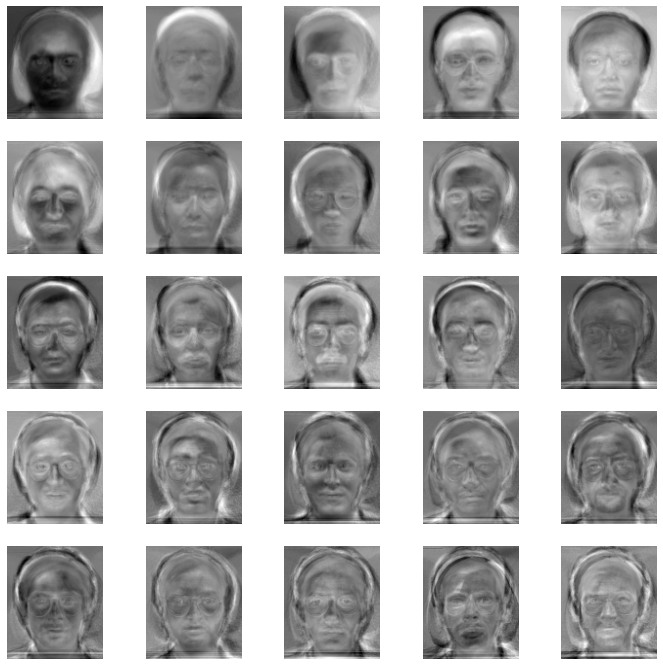

In [11]:
# eigenface
EF = W.reshape(HEIGHT, WIDTH, -1).transpose(2, 0, 1) # (N, H, W)
show_basis_faces(EF, HEIGHT, WIDTH)

## Reconstruction

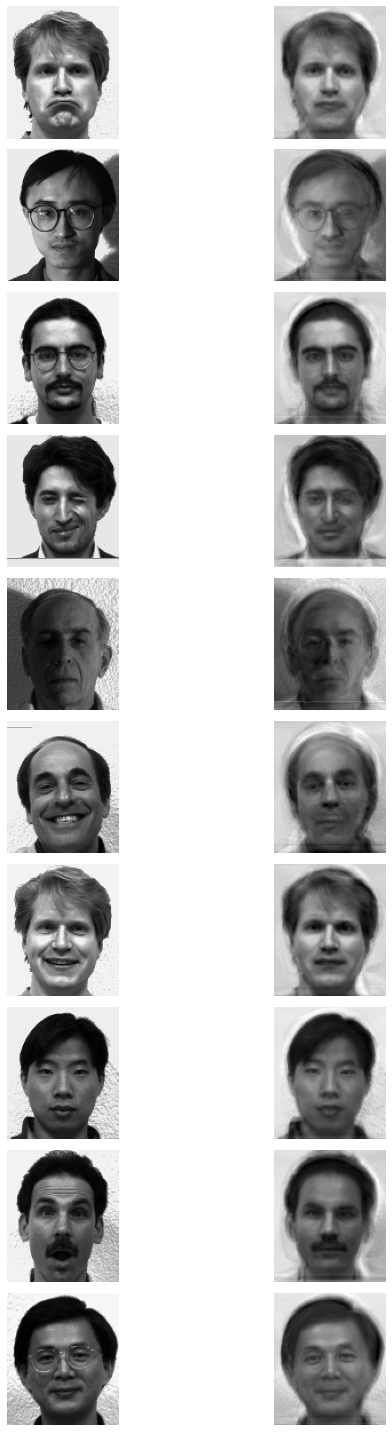

In [12]:
random_index = np.random.choice(X_train.shape[0], 10) # randomly pick 10 images

X_train_mean = np.mean(X_train, axis=0, keepdims=True)

# reduce dimension
Z = (X_train[random_index] - X_train_mean) @ W # Z: row vectors

# reconstruction
X_rec = Z @ W.T + X_train_mean

show_reconstruct_faces(X_train[random_index], X_rec, HEIGHT, WIDTH)

## Classification (k-NN)

In [13]:
X_train_mean = np.mean(X_train, axis=0, keepdims=True)

# reduce dimension
Z_train = (X_train - X_train_mean) @ W
Z_test = (X_test - X_train_mean) @ W

In [14]:
Y_test_pred = KNN(Z_train, Y_train, Z_test, k=5)

# accuracy
acc = np.mean(Y_test == Y_test_pred)
print(acc)

0.8666666666666667


# LDA

In [15]:
def LDA(X, Y, k=25):
    
    X = X.T # each column is a sample
    
    d = X.shape[0] # dimension of data
    n_classes = np.max(Y) + 1 # #classes
    
    # X mean
    X_mean = np.mean(X, axis=1, keepdims=True) # (d, 1)
    
    # X mean by class
    X_class_mean = np.empty((d, n_classes)) # (d, n_classes)
    
    for i in range(n_classes):
        X_class_mean[:, i] = np.mean(X[:, Y == i], axis=1)
    
    
    # within-class scatter (S_W)
    S_W = np.zeros((d, d)) # (d, d)
    
    for i in range(n_classes):
        X_offset = X[:, Y == i] - X_class_mean[:, i, None] # (d, n_i)
        S_W += X_offset @ X_offset.T
    
    
    # between-class scatter (S_B)
    M_offset = X_class_mean - X_mean # (d, n_classes)
    N = np.bincount(Y, minlength=n_classes) # (n_classes,)
    S_B = (N * M_offset) @ M_offset.T # (d, d)
    
    # calculate eig of (S_W^-1 S_B)
#     eigenvalue, eigenvector = np.linalg.eig(np.linalg.pinv(S_W, hermitian=True) @ S_B)
#     np.save('LDA_X_train_half_scale_eigenvalue.npy', eigenvalue)
#     np.save('LDA_X_train_half_scale_eigenvector.npy', eigenvector)
    
    # use precomputed ones
    eigenvalue = np.load('LDA_X_train_half_scale_eigenvalue.npy')
    eigenvector = np.load('LDA_X_train_half_scale_eigenvector.npy').real # in order to visualize fisherfaces
    
    # sort eigenvector by eigenvalue in descending order
    sorted_index = np.argsort(eigenvalue)[::-1]
    W = eigenvector[:, sorted_index[:k]]
    
    return W

## Projection Matrix

In [16]:
W = LDA(X_train, Y_train)

## Fisherfaces

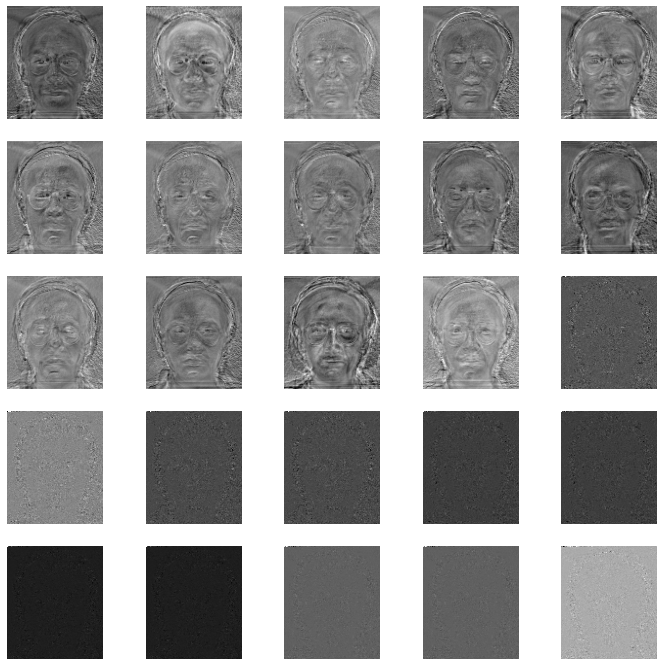

In [17]:
# fisherface
EF = W.reshape(HEIGHT, WIDTH, -1).transpose(2, 0, 1) # (N, H, W)
show_basis_faces(EF, HEIGHT, WIDTH)

## Reconstruction

In [18]:
W = LDA(X_train, Y_train, k=14) # S_B has at most rank 14

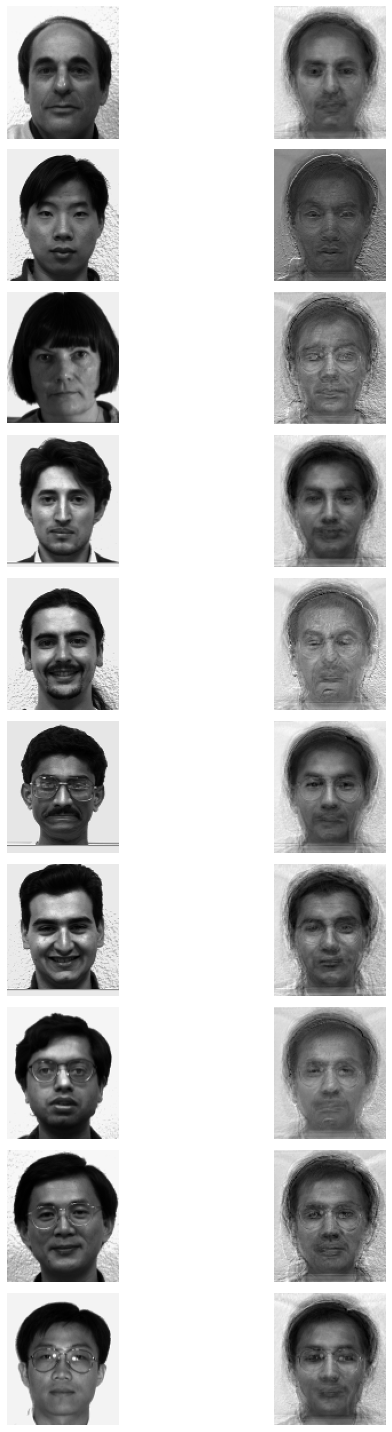

In [19]:
random_index = np.random.choice(X_train.shape[0], 10) # randomly pick 10 images

X_train_mean = np.mean(X_train, axis=0, keepdims=True)

# reduce dimension
Z = (X_train[random_index] - X_train_mean) @ W # Z: row vectors

# reconstruction
X_rec = Z @ W.T + X_train_mean

show_reconstruct_faces(X_train[random_index], X_rec, HEIGHT, WIDTH)

## Classification (k-NN)

In [20]:
X_train_mean = np.mean(X_train, axis=0, keepdims=True)

# reduce dimension
Z_train = (X_train - X_train_mean) @ W
Z_test = (X_test - X_train_mean) @ W

In [21]:
Y_test_pred = KNN(Z_train, Y_train, Z_test, k=5)

# accuracy
acc = np.mean(Y_test == Y_test_pred)
print(acc)

0.9666666666666667


# Kernel PCA

In [22]:
# math derivation from
# https://blog.csdn.net/zhangping1987/article/details/30492433

def KPCA(K, k=25):
    
    # center K
    K = K - np.mean(K, axis=0, keepdims=True) - np.mean(K, axis=1, keepdims=True) + np.mean(K)
    
    # calculate eig
    eigenvalue, eigenvector = eigh(K)
#     np.save('KPCA_RBF_X_train_half_scale_eigenvalue.npy', eigenvalue)
#     np.save('KPCA_RBF_X_train_half_scale_eigenvector.npy', eigenvector)

    # use precomputed ones
#     eigenvalue = np.load('KPCA_RBF_X_train_half_scale_eigenvalue.npy')
#     eigenvector = np.load('KPCA_RBF_X_train_half_scale_eigenvector.npy')

    # sort eigenvector by eigenvalue in descending order
    sorted_index = np.argsort(eigenvalue)[::-1]
    W = eigenvector[:, sorted_index[:k]] / eigenvalue[sorted_index[:k]] ** 0.5 # normalize
    
    return W

## Kernel Function

In [23]:
def RBF_kernel(X1, X2, gamma=5/11368):
    return np.exp(-gamma * cdist(X1, X2, 'sqeuclidean'))

def Polynomial_kernel(X1, X2, gamma=1/11368, degree=5, coef0=0):
    return (gamma * (X1 @ X2.T) + coef0) ** degree

## RBF Kernel

### Projection Matrix

In [24]:
K_train = RBF_kernel(X_train, X_train)
W = KPCA(K_train)

### Classification (k-NN)

In [25]:
K_test = RBF_kernel(X_train, X_test) # K(train, test)

# center K_test
# https://blog.csdn.net/zhangping1987/article/details/30492433
K_test = K_test - np.mean(K_test, axis=0, keepdims=True) - np.mean(K_train, axis=1, keepdims=True) + np.mean(K_train)

# reduce dimension
Z_train = K_train.T @ W
Z_test = K_test.T @ W

In [26]:
Y_test_pred = KNN(Z_train, Y_train, Z_test, k=5)

# accuracy
acc = np.mean(Y_test == Y_test_pred)
print(acc)

0.8666666666666667


## Polynomial Kernel

### Projection Matrix

In [27]:
K_train = Polynomial_kernel(X_train, X_train)
W = KPCA(K_train)

### Classification (k-NN)

In [28]:
K_test = Polynomial_kernel(X_train, X_test) # K(train, test)

# center K_test
K_test = K_test - np.mean(K_test, axis=0, keepdims=True) - np.mean(K_train, axis=1, keepdims=True) + np.mean(K_train)

# reduce dimension
Z_train = K_train.T @ W
Z_test = K_test.T @ W

In [29]:
Y_test_pred = KNN(Z_train, Y_train, Z_test, k=4)

# accuracy
acc = np.mean(Y_test == Y_test_pred)
print(acc)

0.36666666666666664


# Kernel LDA

In [30]:
# https://en.wikipedia.org/wiki/Kernel_Fisher_discriminant_analysis

def KLDA(K, Y, k=25):
    
    # centralize K
    K = K - np.mean(K, axis=0, keepdims=True) - np.mean(K, axis=1, keepdims=True) + np.mean(K)
    
    n_classes = np.max(Y) + 1
    
    # within-class scatter (N=S_W)
    N = np.zeros_like(K)
    for j in range(n_classes):
        K_j = K[:, Y == j]
        lj = K_j.shape[1]
        N_1lj = np.ones((lj, lj)) / lj
        N += K_j @ (np.eye(lj) - N_1lj) @ K_j.T
    
    
    # between-class scatter (M=S_B)
    M = np.zeros_like(K)
    M_star = np.mean(K, axis=1, keepdims=True)
    
    for j in range(n_classes):
        M_j = np.mean(K[:, Y == j], axis=1, keepdims=True)
        M_offset = M_j - M_star
        M += np.count_nonzero(Y == j) * M_offset @ M_offset.T
    
    
    # calculate eig of (N^-1 M)
    eigenvalue, eigenvector = np.linalg.eig(np.linalg.pinv(N) @ M)
    
    
    # sort eigenvector by eigenvalue in descending order
    sorted_index = np.argsort(eigenvalue)[::-1]
    W = eigenvector[:, sorted_index[:k]] / eigenvalue[sorted_index[:k]] ** 0.5 # normalize
    
    return W.real

## Kernel Function

In [31]:
def RBF_kernel(X1, X2, gamma=10/11368):
     return np.exp(-gamma * cdist(X1, X2, 'sqeuclidean'))

def Polynomial_kernel(X1, X2, gamma=1/11368, degree=5, coef0=1):
    return (gamma * (X1 @ X2.T) + coef0) ** degree

## RBF Kernel

### Projection Matrix

In [32]:
K_train = RBF_kernel(X_train, X_train)
W = KLDA(K_train, Y_train, k=14)

### Classification (k-NN)

In [33]:
K_test = RBF_kernel(X_train, X_test) # K(train, test)

# centralize K_test
K_test = K_test - np.mean(K_test, axis=0, keepdims=True) - np.mean(K_train, axis=1, keepdims=True) + np.mean(K_train)

# reduce dimension
Z_train = K_train.T @ W
Z_test = K_test.T @ W

In [34]:
Y_test_pred = KNN(Z_train, Y_train, Z_test, k=5)

# accuracy
acc = np.mean(Y_test == Y_test_pred)
print(acc)

0.9


## Polynomial Kernel

### Projection Matrix

In [35]:
K_train = Polynomial_kernel(X_train, X_train)
W = KLDA(K_train, Y_train, k=14)

### Classification (k-NN)

In [36]:
K_test = Polynomial_kernel(X_train, X_test) # K(train, test)

# centralize K_test
K_test = K_test - np.mean(K_test, axis=0, keepdims=True) - np.mean(K_train, axis=1, keepdims=True) + np.mean(K_train)

# reduce dimension
Z_train = K_train.T @ W
Z_test = K_test.T @ W

In [37]:
Y_test_pred = KNN(Z_train, Y_train, Z_test, k=9)

# accuracy
acc = np.mean(Y_test == Y_test_pred)
print(acc)

0.9666666666666667
